In [1]:
import rebound
import numpy as np
%matplotlib inline

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-5, P=1.,e=0.01)
sim.add(m=1.e-5, P=1.11, e=0.02)
ps = sim.particles

ps[1].r = ps[1].a*(ps[1].m/ps[0].m/3)**(1/3)
ps[2].r = ps[2].a*(ps[2].m/ps[0].m/3)**(1/3)
sim.move_to_com()

# Key params

In [2]:
sim.collision="line" # better collision detection routine (not a big deal)
sim.integrator="whfast"
sim.dt = 0.05*ps[1].P*(1-ps[1].e)**1.5 / np.sqrt(1+ps[1].e) # correction for resolving eccentric orbits (doesn't matter for your application but will in cases where e=0.9!)
sim.ri_whfast.safe_mode=0 # This will make the nbody integration run twice as fast. It is fine as long as we don't have any extra forces between timesteps (e.g. reboundx)

sim.save('testarchive.bin')

# Test we can load the snapshot

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


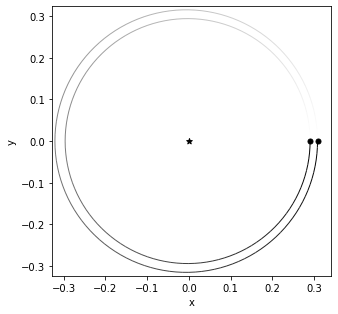

In [3]:
filename = 'testarchive.bin'
sa = rebound.SimulationArchive(filename)
sim = sa[0]
sim.integrator_synchronize() # because safe_mode = 0 we have to manually synchronize the integrator when we reload snapshots
fig = rebound.OrbitPlot(sim)

# How we would run it on the cluster

Note that automatesimulationarchive always APPENDS to the file. If you tried loading the first snapshot and running twice, you would have snapshots going up to collision followed by snapshots starting over from 0 to collision. You can delete an exisiting file of that name with deletefile=True, but obviously runs the danger of deleting expensive runs!

In [4]:
# save an archive every 1000 orbits. 
# Probably want to save every 1e6 orbits for yours, otherwise will run slower from always writing to disk
# Will keep each archive down to a max of a few MB

sim.automateSimulationArchive(filename, interval=1.e3*sim.particles[1].P) 
try:
    sim.integrate(1e5, exact_finish_time=0)
# Manually append a snapshot in event of a collision so you have final state
except rebound.Collision: 
    sim.simulationarchive_snapshot('testarchive.bin')

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:685: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


In [20]:
sa = rebound.SimulationArchive(filename)
sim0 = sa[0]
E0 = sim0.calculate_energy()
for i, sim in enumerate(sa):
    sim.integrator_synchronize() # because safe_mode = 0 we have to manually synchronize the integrator when we reload snapshots
    E = sim.calculate_energy()
    print("Snapshot {0}: e={1}, Rel. Energy Error={2:.3e}".format(i, sim.particles[1].e, np.abs((E-E0)/E0)))

Snapshot 0: e=0.009999999999999964, Rel. Energy Error=0.000e+00
Snapshot 1: e=0.009999999999999964, Rel. Energy Error=0.000e+00
Snapshot 2: e=0.010336358308612865, Rel. Energy Error=1.333e-06
Snapshot 3: e=0.03745262760487762, Rel. Energy Error=1.336e-06
Snapshot 4: e=0.05970369233405406, Rel. Energy Error=1.336e-06
Snapshot 5: e=0.051667161407021545, Rel. Energy Error=1.335e-06
Snapshot 6: e=0.07709400685392558, Rel. Energy Error=1.350e-06
Snapshot 7: e=0.06543450627043887, Rel. Energy Error=1.108e-06
Snapshot 8: e=0.04138357108892869, Rel. Energy Error=1.332e-06
Snapshot 9: e=0.09921989437239447, Rel. Energy Error=1.243e-06
Snapshot 10: e=0.1064575734887504, Rel. Energy Error=1.043e-06
Snapshot 11: e=0.07326638952810191, Rel. Energy Error=1.413e-06
Snapshot 12: e=0.07692535392490193, Rel. Energy Error=1.508e-06
Snapshot 13: e=0.07939002720007324, Rel. Energy Error=1.115e-06
Snapshot 14: e=0.08839872270737321, Rel. Energy Error=4.810e-07
Snapshot 15: e=0.07505790135899702, Rel. Energy

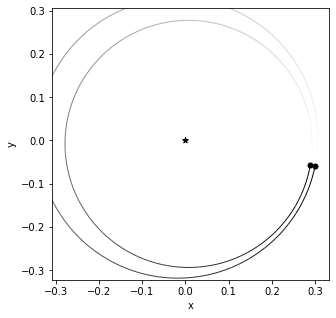

In [6]:
lastsim = sa[-1]
fig = rebound.OrbitPlot(lastsim)